# Plotting Velocity Fields on Horizontal Planes (Depth Slices)

This notebook contains discussion, examples, and best practices for plotting velocity field results from NEMO. It extends the discussion of horizontal plane visualizations in the [Plotting Bathymetry Colour Meshes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Bathymetry%20Colour%20Meshes) and [Plotting Tracers on Horizontal Planes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Tracers%20on%20Horizontal%20Planes.ipynb) notebooks with plotting of quiver and streamline plots in addition to colour mesh plots.
Topics include:

* Reading velocity component values from NEMO `*grid_[UVW].nc` results files
* Plotting colour meshes of velocity components
* "Un-staggering" velocity component values for vector plots
* Quiver plots of velocity vectors
* Streamline plots of velocity fields

We'll start with our imports, and activation of the Matplotlib inline backend:

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from IPython.display import display, Math, Latex

from salishsea_tools import (
    nc_tools,
    viz_tools,
)

In [2]:
%matplotlib inline

## NEMO `grid_U`, `grid_V`, and `grid_W` Results Files

In NEMO,
velocity component values are stored at the u, v, and w grid point locations of an
[Akawara C grid](http://clouds.eos.ubc.ca/~phil/numeric/labs/lab7/lab7.pdf#section.7)
which NEMO calls the U-grid, V-grid, and W-grid,
respectively.

The results files that contain the velocity component values for a run have names like:
```bash
    SalishSea_1h_20021026_20021026_grid_U.nc
    SalishSea_1h_20021026_20021026_grid_V.nc
    SalishSea_1h_20021026_20021026_grid_W.nc
```
The breakdown of the parts of those file names is the same as for the `grid_T` files
described in the [NEMO grid_T Results Files](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Tracers%20on%20Horizontal%20Planes.ipynb#nemo-grid_t-results-files) section of the Plotting Tracers on Horizontal Planes notebook.

We'll use results files from one of the spin-up runs that are stored in
the `/results/SalishSea/spin-up/2002/` directory.
Let's load the files into netCDF dataset objects and look at the dimensions of the U-grid dataset:

In [3]:
u_vel = nc.Dataset('/results/SalishSea/spin-up/2002/26oct/SalishSea_1h_20021026_20021026_grid_U.nc')
v_vel = nc.Dataset('/results/SalishSea/spin-up/2002/26oct/SalishSea_1h_20021026_20021026_grid_V.nc')
w_vel = nc.Dataset('/results/SalishSea/spin-up/2002/26oct/SalishSea_1h_20021026_20021026_grid_W.nc')

In [4]:
nc_tools.show_dimensions(u_vel)

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'depthu', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24

<class 'netCDF4._netCDF4.Dimension'>: name = 'tbnds', size = 2



The dimensions of the velocity component datasets are the same as those of the tracers dataset
(see the [Plotting Tracers on Horizontal Planes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Tracers%20on%20Horizontal%20Planes.ipynb#nemo-grid_t-results-files) notebook)
with the exception of the depth dimension,
which is called `depthu` rather than `deptht`.
Likewise,
the depths dimensions of the v and w velocity component datasets
are `depthv` and `depthw`,
respectively.
These are simply nominal depths and so the u,v and t grid layer depths have the same values. But note that the w grid layer depth has different values.

Oddly,
the lateral dimensions, 
`x` and `y`, of the grid points of the T, U, V, and W which actually are different (not simply nominal),
lack any such notation differentiation.

Now let's look at the variables in the datasets:

In [5]:
nc_tools.show_variables(u_vel)

odict_keys(['nav_lon', 'nav_lat', 'depthu', 'time_counter', 'time_counter_bnds', 'vozocrtx', 'u_wind_stress'])


The first 5 variables correspond to the dataset's dimensions:

* `nav_lon` and `nav_lat` contain the longitudes and latitudes of lateral grid points
* `depthu` contains the depths of the vertical grid layers
* `time_counter` contains the model time values at the centre of each of the output intervals
* `time_counter_bnds` contains the start and end times of each of the intervals in `time_counter`

The other 2 are calculated values from NEMO:

* `vozocrtx` is the u (zonal) velocity component
* `u_wind_stress` is the u component of the surface wind stress

In the V-grid dataset we have:

In [6]:
nc_tools.show_variables(v_vel)

odict_keys(['nav_lon', 'nav_lat', 'depthv', 'time_counter', 'time_counter_bnds', 'vomecrty', 'v_wind_stress'])


where:

* `vomecrty` is the v (meridonal) velocity component
* `v_wind_stress` is the v componenent of the surface wind stress

and in the W-grid dataset we find:

In [7]:
nc_tools.show_variables(w_vel)

odict_keys(['nav_lon', 'nav_lat', 'depthw', 'time_counter', 'time_counter_bnds', 'vovecrtz'])


where:

* `vovecrtz` is the w (vertical) velocity component

##Plotting Velocity Component Colour Meshes

Velocity component values are scalars,
so plotting them as colour meshes is really no different than
plotting temperature and salinity fields
(see the [Plotting Tracers on Horizontal Planes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Tracers%20on%20Horizontal%20Planes.ipynb) notebook).

##"Un-staggering" u and v Components

The u, v and w velocity components are all stored at different locations on the grid.

![](GridCube.png)

*Figure 4.1 from the NEMO 3.4 Book, G. Madec, and the NEMO Team, (2012), ISSN 1288-1619*

Recall that our grid cells are nominally 500 m in the y direction by 440 m in the x direction.
To obtain an accurate velocity vector value for a grid cell we interpolate the u and v
component values to the T-grid point in the centre of the grid cell.
The `salissea_tools.viz_tools.unstagger()` function is provided to do the necessary interploation.

In [8]:
help(viz_tools.unstagger)

Help on function unstagger in module salishsea_tools.viz_tools:

unstagger(ugrid, vgrid)
    Interpolate u and v component values to values at grid cell centres.
    
    The shapes are the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`



There is a significant scale difference between the lateral and vertical in the model.
The vertical layer thicknesses vary from 1 m near the surface to 27 m near the bottom,
and the w component values are typically an order of magnitude or more smaller than
the u or v components at a given grid points.
So,
we don't worry about interpolating the w components to the T-grid point.

## Velocity Quiver Plots

Let's alias the u and v velocity component variables,
the depth layer midpoint variable,
and the time counter variable,
to save on keystrokes:

In [9]:
ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']
zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']

Quiver plots are plots of velocity vectors
(or other vector quantities)
as arrows on a spatial grid.
To avoid doing calculations on values that aren't going to be displayed
we start by calculating the slices of the u and v arrays that we want to
visualize and masking the zero values to apply an approximate land mask.
Next,
we unstagger those slices,
then we plot the vectors,
set the axes limits,
and,
add axes labels and a title.

Note that the x and y slice arrays that we pass to `quiver()`
have their first element dropped so that they match the shape
of the un-staggered velocity component arrays.

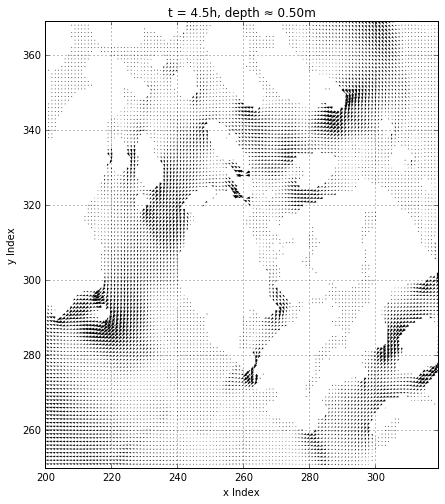

In [10]:
# Define the slice to plot
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
ax.quiver(x_slice[1:], y_slice[1:], u_tzyx, v_tzyx)
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

The `salishsea_tools.viz_tools.plot_land_mask()` function
uses a bathymetry file or dataset to plot the land areas as
filled polygons:

In [11]:
help(viz_tools.plot_land_mask)

Help on function plot_land_mask in module salishsea_tools.viz_tools:

plot_land_mask(axes, bathymetry, coords='grid', isobath=0, xslice=None, yslice=None, color='black')
    Plot land areas from bathymetry as solid colour ploygons on the axes.
    
    The bathymetry data may be specified either as a file path/name,
    or as a :py:class:`netCDF4.Dataset` instance.
    If a file path/name is given it is opened and read into a
    :py:class:`netCDF4.Dataset` so,
    if this function is being called in a loop,
    it is best to provide it with a bathymetry dataset to avoid
    the overhead of repeated file reads.
    
    :arg axes: Axes instance to plot the land mask ploygons on.
    :type axes: :py:class:`matplotlib.axes.Axes`
    
    :arg bathymetry: File path/name of a netCDF bathymetry data file
                     or a dataset object containing the bathymetry data.
    :type bathymetry: str or :py:class:`netCDF4.Dataset`
    
    :arg coords: Type of plot coordinates to set the a

Let's "down-sample" the velocity field by plotting the vector at every 3rd grid point,
and plot the land areas in black.

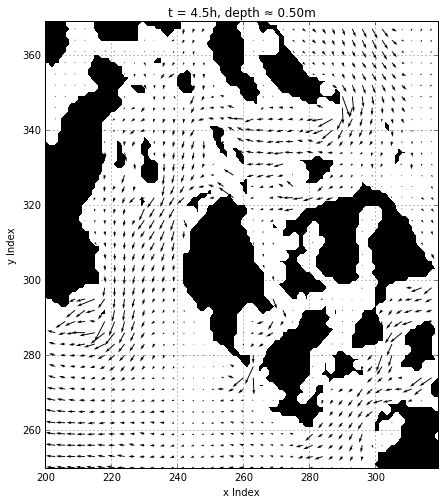

In [12]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
ax.quiver(x_slice_a[:], y_slice_a[:], u_tzyx[::3,::3], v_tzyx[::3,::3])
viz_tools.plot_land_mask(ax, '/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

Notice that changing the number of vector arrows plotted also
changed the size of the arrows thanks to `quiver()`'s auto-scaling algorithm.

Also,
passing the x and y slices that define the section of the domain that we're working in
to `viz_tools.plot_land_mask()` results in a significantly faster rendering of the plot.
That is because calling `viz_tools.plot_land_mask()` without the slice arguments means
that the land mask polygons for the entire domain are calculated and then those outside the
plot limits are simply discarded.
Similarly,
if you are calling `viz_tools.plot_land_mask()` or `viz_tools.plot_coastline()` several times
in a notebook,
it is worth loading the bathymetry into a netCDF4 dataset once and passing the dataset object
instead of its path and file name.

In [13]:
bathy = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

Now,
let's add some colour,
move the arrows to that they are centred on the T-grid locations,
and add a scale key for the arrow lengths:

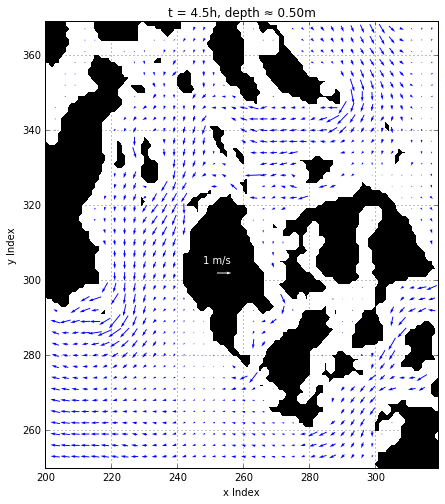

In [14]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice_a, x_slice_a], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice_a, x_slice_a], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx, v_tzyx, color='blue', pivot='mid')
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 252, 302, 1, '1 m/s', coordinates='data', color='white', labelcolor='white')

`quiver()` has a number of optional arguments that allow you to
tune the appearance of your plots
(see the [docs](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.quiver) for details).
Here we use the velocity magnitudes to apply a colour map to the arrows,
and adjust the width of the arrow shafts:

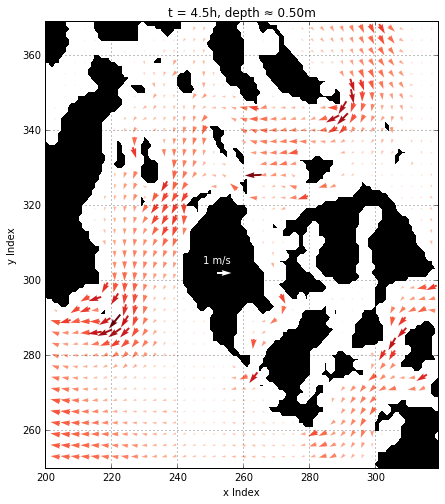

In [15]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice_a, x_slice_a], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice_a, x_slice_a], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(
    x_slice_a[1:], y_slice_a[1:], u_tzyx, v_tzyx, speeds,
    pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 252, 302, 1, '1 m/s', coordinates='data', color='white', labelcolor='white')

Note the use of `np.square()` in the calculation of the velocity magnitudes:

```python
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
```

in contrast to using the Python exponentiation operator:

```python
speeds = np.sqrt(u_tzyx**2 + v_tzyx**2)
```

The `u_tzyx` and `v_tzyx` arrays are NumPy masked arrays that contain `NaN`
as mask values.
While raising `NaN` to the power 2 doesn't seem to cause problems,
calculating the square root of `NaN` results in a warning like:

```
-c:3: RuntimeWarning: invalid value encountered in sqrt
```

the first time the cell is executed.
The warning appears only the first time the cell is run because,
by default,
Python only shows runtime errors once per interpreter session.

Using `np.square()` and `np.sqrt()` ensures that the `NaN` values
are handled properly through the entire calculation.

## Velocity Streamline Plots

Streamline plots are plots of velocities
(or other vector quantities)
as line segments on a spatial grid.

As for quiver plots,
we want to avoid doing calculations on values that aren't going to be displayed,
so we calculate the slices of the u and v arrays that we want to
visualize and mask the zero values to apply an approximate land mask.

We also need to un-stagger the velocity slices,
and,
as was the case for `quiver()`,
the x and y slice arrays that we pass to `streamplot()`
have their first element dropped so that they match the shape
of the un-staggered velocity component arrays.

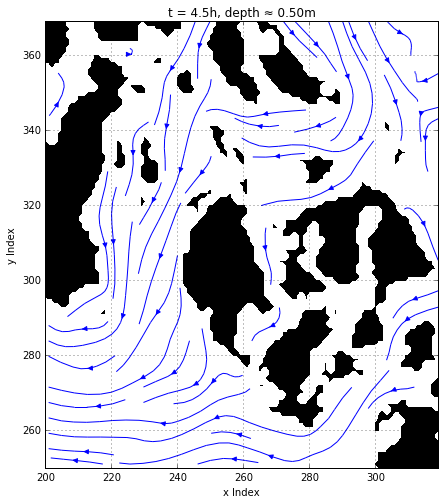

In [16]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

ax.streamplot(x_slice[1:], y_slice[1:], u_tzyx, v_tzyx)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

The default operation of `streamplot()` is to divide the plot domain into a 25x25 grid. 
Each cell in that grid can have,
at most,
one traversing streamline.
`streamplot()` takes a `density` argument with a default value of 1
which linearly scales that grid and thereby controls
the closeness of the streamlines.
For different densities in each direction,
use a `(density_x, density_y)` tuple value for `density`.

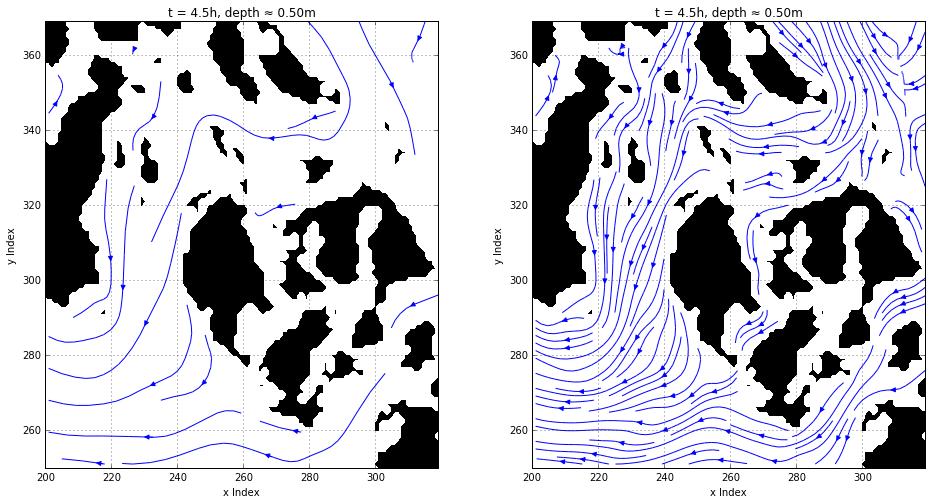

In [17]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
densities = (0.5, 2)
for ax, density in zip(axs, densities):
    viz_tools.set_aspect(ax)

    ax.streamplot(
        x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
        density=density,
    )
    viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

    ax.set_xlim(x_slice[0], x_slice[-1])
    ax.set_ylim(y_slice[0], y_slice[-1])
    ax.grid()

    ax.set_xlabel('x Index')
    ax.set_ylabel('y Index')
    ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

`streamplot()` also accepts an optional `linewidth` argument
to allow the line widths to be varied.
We can use that to make the width of the streamlines indicate
the velocity magnitude:

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


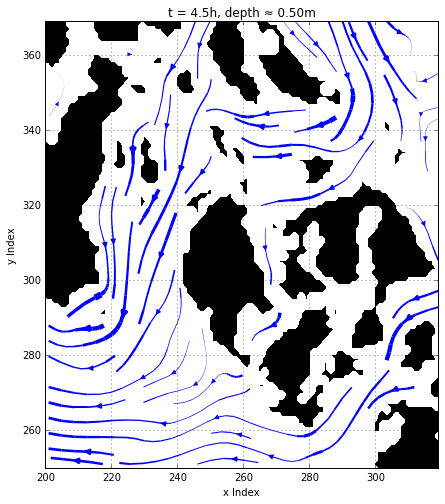

In [18]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
max_speed = viz_tools.calc_abs_max(speeds)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

ax.streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=7*speeds/max_speed,
)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

Another useful `streamplot()` argument is which allows a colour map to be applied
along the streamline lenghts.
We can use that to vary the colour intensity as well as the line width
of the streamlines to indicate the velocity magnitude:

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


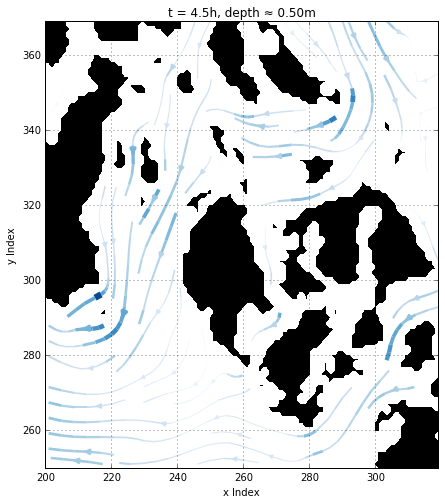

In [19]:
t, zlevel = 4, 0
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
max_speed = viz_tools.calc_abs_max(speeds)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

streams = ax.streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=7*speeds/max_speed,
    color=speeds, cmap='Blues',
)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

## Changing the Coordinate System
The NEMO grid is oriented at 29 degree N/W from the North in order to have it align with the major currents through the Georgia Strait. However, when performing comparisons with other sources we may need to rotate the grid to align it with the North, a more common reference point.

First, we need to unstagger the velocities in order to be rotating them from a single centered point on the grid. Then we can rotate the velocities to have u velocities be E/W and v velocities be N/S. The w velocities will remain the same.
To do this we can perform our change of coordinate system by using the following equations, where theta is in radians: 

In [20]:
display(Math(r'u = xcos(\theta)-ysin(\theta)'))
display(Math(r'v = xsin(\theta)+ycos(\theta)'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
t = nc.Dataset('/results/SalishSea/spin-up/2002/26oct/SalishSea_1h_20021026_20021026_grid_T.nc')
lats = t.variables['nav_lat']
lons = t.variables['nav_lon']

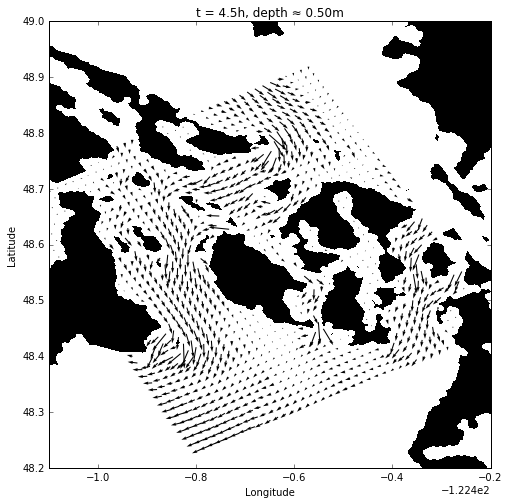

In [22]:
t, zlevel = 4, 0
step = 3
y_slice = np.arange(250, 370)
x_slice = np.arange(200, 320)

lats_slice = lats[250:370, 200:320]
lons_slice = lons[250:370, 200:320]

theta=29
theta_rad=29 * np.pi / 180

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

u_E=u_tzyx * np.cos(theta_rad) - v_tzyx * np.sin(theta_rad)
v_N=u_tzyx * np.sin(theta_rad) + v_tzyx * np.cos(theta_rad)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

ax.quiver(lons_slice[1::3, 1::3], lats_slice[1::3, 1::3], u_E[::3,::3], v_N[::3,::3])
viz_tools.plot_land_mask(ax, bathy, coords='map', color='k')

ax.set_xlim([-123.5, -122.6])
ax.set_ylim([48.2, 49.0])
#ax.grid()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))